celkovy optimalizacni backtest na vetsim oknu 1 - 300
a možná take to udělat jako parametr
zkusit CV
zobrazit nejak robustnost parametru

Activating profile profile1

Profile profile1 loaded successfully.

Current values:
{
    'AGG_EXCLUDED_TRADES': ['C', 'O', '4', 'B', '7', 'V', 'P', 'W', 'U', 'Z', 'F'],
    'BT_DELAYS': {
        'trigger_to_strat': 0.02,
        'strat_to_sub': 0.023,
        'sub_to_fill': 0.008,
        'fill_to_not': 0.023,
        'limit_order_offset': 0
    },
    'BT_FILL_CONDITION_BUY_LIMIT': <FillCondition.SLOW: 'slow'>,
    'BT_FILL_CONDITION_SELL_LIMIT': <FillCondition.SLOW: 'slow'>,
    'BT_FILL_CONS_TRADES_REQUIRED': 2,
    'BT_FILL_LOG_SURROUNDING_TRADES': 10,
    'BT_FILL_PRICE_MARKET_ORDER_PREMIUM': 0.005,
    'COUNT_API_REQUESTS': False,
    'GROUP_TRADES_WITH_TIMESTAMP_LESS_THAN': 0.003,
    'ILOG_SAVE_LEVEL_FROM': 1,
    'LIVE_DATA_FEED': 'sip',
    'NORMALIZED_TICK_BASE_PRICE': 30.0,
    'OFFLINE_MODE': False,
    'PROD_SERVER_HOSTNAMES': ['tradingeastcoast', 'David-MacBook-Pro.local'],
    'QUIET_MODE': True,
    'TEST_SERVER_HOSTNAMES': ['tradingtest']
}

config_handler.active_profile='profile1'

config handler initialized

Realtime Websocket connection will use FEED: sip and credential of ACCOUNT1



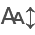

In [1]:
from v2realbot.tools.loadbatch import load_batch
from v2realbot.utils.utils import zoneNY
import pandas as pd
import numpy as np
import vectorbtpro as vbt
from itables import init_notebook_mode, show
import datetime
from itertools import product

init_notebook_mode(all_interactive=True)

vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280
vbt.settings.plotting.auto_rangebreaks = True
# Set the option to display with pagination
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_rows', 10)  # Number of rows per page

# Define the market open and close times
market_open = datetime.time(9, 30)
market_close = datetime.time(16, 0)
entry_window_opens = 1
entry_window_closes = 370

forced_exit_start = 380
forced_exit_end = 390

res, df = load_batch(batch_id="f1ac6651", #138170bc 0fb5043a  bde6d0be f1ac6651
                     space_resolution_evenly=False,
                     indicators_columns=["Rsi14"],
                     main_session_only=True,
                     verbose = False)
if res < 0:
    print("Error" + str(res) + str(df))
df = df["bars"]

df

basic_data = vbt.Data.from_data(vbt.symbol_dict({"BAC": df}), tz_convert=zoneNY)
#m1_data = basic_data[['Open', 'High', 'Low', 'Close', 'Volume']]
basic_data = basic_data.transform(lambda df: df.between_time('09:30', '16:00'))
#basic_data.info()

In [3]:
vbt.open_api_ref(vbt.base)

vbt

<module 'vectorbtpro' from '/Users/davidbrazda/Documents/Development/python/v2trading/.venv/lib/python3.10/site-packages/vectorbtpro/__init__.py'>

In [18]:
##na toto udelat crosssvalidationu nebo alespon na testovacim ci jinem obdobi
#take udelat long leg - tato je shortovaci

#8	-0.06	-0.2	0.0028	0.0048	4.156254

#short combination ok for train(4)/test(0.1) (window 1-90, fe 95-100)
#2,	-0.02,	-0.25,	0.0018,	0.0068

#dalsi ok hodnota shortu for train/test 4/1
#70,	8,	-0.06,	-0.2,	0.0013,	0.0053	


#kombinace bez roc_th, train/test 7/-1.5
#70	7	-0.07	0.0033	0.0063

#opet bez roc_th, train(5.77)/test 0.9 - spolus tsl_stop + tsl_th
#29	7	-0.09	0.0033	0.0068

#bez roc_th a s trailing sl train/test 8.1/-0.8 
#70	2	-0.05	0.0018	0.0068


# TODO:
#- vyzkouset zda nejvyhodnejsi kombinace krom train/testu funguje i na nasledujicich dnech po trainu
# -zkusit najit v short datasetu neco vyhodneho co funguji i na testu
# - dodelat kombinace pro long signaly
# - zkusit walk forward
# - vytvorit vysledkove totoznou na v2realbot
# - podivat se jak detailne funguji tsl_stop a tsl_th

#70,	4,	-0.07,	0.0048,	0.0068	


entry_window_closes, mom_timeperiod, mom_th, sl_stop, tp_stop = 8,	3,	0.07,	0.0028,	0.0033	
roc_th  = 0
momshort = vbt.indicator("talib:MOM").run(basic_data.close, timeperiod=mom_timeperiod, short_name = "slope_short")
rocp = vbt.indicator("talib:ROC").run(basic_data.close, short_name = "rocp")
#rate of change + momentum

#momshort.plot rocp.real_crossed_below(roc_th) & 
short_signal = momshort.real_crossed_below(mom_th)

long_signal = momshort.real_crossed_above(mom_th)

# print("short signal")
# print(short_signal.value_counts())

#forced_exit = pd.Series(False, index=close.index)
forced_exit = basic_data.symbol_wrapper.fill(False)
#entry_window_open = pd.Series(False, index=close.index)
entry_window_open=  basic_data.symbol_wrapper.fill(False)

# Calculate the time difference in minutes from market open for each timestamp
elapsed_min_from_open = (forced_exit.index.hour - market_open.hour) * 60 + (forced_exit.index.minute - market_open.minute)

entry_window_open[(elapsed_min_from_open >= entry_window_opens) & (elapsed_min_from_open < entry_window_closes)] = True

#print(entry_window_open.value_counts())

forced_exit[(elapsed_min_from_open >= forced_exit_start) & (elapsed_min_from_open < forced_exit_end)] = True
short_entries = (short_signal & entry_window_open)
short_exits = forced_exit

entries = (long_signal & entry_window_open)
exits = forced_exit
#long_entries.info()
#number of trues and falses in long_entries
# print(short_exits.value_counts())
# print(short_entries.value_counts())

#fig = plot_2y_close([],[momshort, rocp], close)
#short_signal.vbt.signals.plot_as_entries(close, fig=fig, add_trace_kwargs=dict(secondary_y=False))
#print(sl_stop)
#short_entries=short_entries, short_exits=short_exits,
pf = vbt.Portfolio.from_signals(close=basic_data, entries=entries, exits=exits, tsl_stop=sl_stop, tp_stop = tp_stop, fees=0.0167/100, freq="1s") #sl_stop=sl_stop, tp_stop = sl_stop,

pf.stats()


Start            2024-01-02 09:30:00-05:00
End              2024-02-28 15:59:59-05:00
Period                     5 days 18:15:46
Start Value                          100.0
Min Value                        99.766637
                           ...            
Expectancy                       -0.058341
Sharpe Ratio                     -3.597608
Calmar Ratio                      -2.69309
Omega Ratio                       0.867176
Sortino Ratio                    -4.934545
Length: 29, dtype: object

In [17]:
pf.plot()

FigureWidget({
    'data': [{'close': array([33.44 , 33.445, 33.42 , ..., 34.325, 34.33 , 34.32 ]),
              'decreasing': {'fillcolor': '#ee534f', 'line': {'color': '#ee534f'}},
              'high': array([33.44 , 33.465, 33.45 , ..., 34.325, 34.33 , 34.33 ]),
              'increasing': {'fillcolor': '#26a69a', 'line': {'color': '#26a69a'}},
              'low': array([33.39, 33.44, 33.42, ..., 34.32, 34.32, 34.32]),
              'name': 'OHLC',
              'opacity': 0.5,
              'open': array([33.39 , 33.46 , 33.45 , ..., 34.32 , 34.325, 34.325]),
              'type': 'candlestick',
              'uid': '62d2f920-d109-44ec-9c98-0def8e4b29b0',
              'x': array([datetime.datetime(2024, 1, 2, 9, 30, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 2, 9, 30, 1, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 2, 9, 30, 2, tzinfo=<DstTzInfo 

In [36]:
pf.get_drawdowns().records_readable

Drawdown Id            Column               Start Index  \
0             0  (0.0018, 0.0068) 2024-01-03 09:31:04-05:00   
1             1  (0.0018, 0.0068) 2024-01-03 09:31:07-05:00   
2             2  (0.0018, 0.0068) 2024-01-03 09:31:11-05:00   
3             3  (0.0018, 0.0068) 2024-01-03 09:31:18-05:00   
4             4  (0.0018, 0.0068) 2024-01-03 09:48:07-05:00   
..          ...               ...                       ...   
34           34  (0.0018, 0.0068) 2024-01-12 12:23:26-05:00   
35           35  (0.0018, 0.0068) 2024-01-12 12:23:31-05:00   
36           36  (0.0018, 0.0068) 2024-01-12 12:32:23-05:00   
37           37  (0.0018, 0.0068) 2024-01-12 12:32:27-05:00   
38           38  (0.0018, 0.0068) 2024-01-12 12:32:36-05:00   

                Valley Index                 End Index  Start Value  \
0  2024-01-03 09:31:05-05:00 2024-01-03 09:31:06-05:00   100.000000   
1  2024-01-03 09:31:10-05:00 2024-01-03 09:31:11-05:00   100.057784   
2  2024-01-03 09:31:13-05:00 2024-01-03 09:31:16-05:00   100.102472   
3  2024-01-03 09:32:39-05:00 2024-01-03 09:48:05-05:00   100.162057   
4  2024-01-03 09:48:08-05:00 2024-01-03 09:48:11-05:00   100.186396   
..                       ...                       ...          ...   
34 2024-01-12 12:23:28-05:00 2024-01-12 12:23:29-05:00   100.981534   
35 2024-01-12 12:26:27-05:00 2024-01-12 12:32:23-05:00   101.089545   
36 2024-01-12 12:32:24-05:00 2024-01-12 12:32:25-05:00   101.089545   
37 2024-01-12 12:32:28-05:00 2024-01-12 12:32:36-05:00   101.104975   
38 2024-02-21 09:35:15-05:00 2024-02-28 15:59:59-05:00   101.104975   

    Valley Value   End Value     Status  
0      99.983303  100.057784  Recovered  
1     100.042888  100.102472  Recovered  
2     100.057784  100.102472  Recovered  
3      99.650958  100.171522  Recovered  
4     100.171522  100.201269  Recovered  
..           ...         ...        ...  
34    100.968881  101.043254  Recovered  
35    100.858092  101.089545  Recovered  
36    101.074115  101.089545  Recovered  
37    101.089545  101.104975  Recovered  
38     99.788058   99.788058     Active  

[39 rows x 9 columns]

In [12]:
pf.orders.records_readable

Order Id  Column              Signal Index            Creation Index  \
0          0       0 2024-01-03 09:31:06-05:00 2024-01-03 09:31:06-05:00   
1          1       0 2024-01-03 09:31:06-05:00 2024-01-03 09:48:40-05:00   
2          2       0 2024-01-04 09:33:14-05:00 2024-01-04 09:33:14-05:00   
3          3       0 2024-01-04 09:33:14-05:00 2024-01-04 09:43:31-05:00   
4          4       0 2024-01-05 09:31:23-05:00 2024-01-05 09:31:23-05:00   
..       ...     ...                       ...                       ...   
51        51       0 2024-02-21 09:34:52-05:00 2024-02-21 09:45:00-05:00   
52        52       0 2024-02-22 09:31:22-05:00 2024-02-22 09:31:22-05:00   
53        53       0 2024-02-22 09:31:22-05:00 2024-02-22 09:38:13-05:00   
54        54       0 2024-02-23 09:31:25-05:00 2024-02-23 09:31:25-05:00   
55        55       0 2024-02-23 09:31:25-05:00 2024-02-23 09:35:02-05:00   

                  Fill Index      Size      Price      Fees  Side    Type  \
0  2024-01-03 09:31:06-05:00  2.981461  33.535000  0.016697  Sell  Market   
1  2024-01-03 09:48:40-05:00  2.981461  33.357264  0.016609   Buy  Market   
2  2024-01-04 09:33:14-05:00  2.976739  33.755000  0.016780  Sell  Market   
3  2024-01-04 09:43:31-05:00  2.976739  33.821568  0.016813   Buy  Market   
4  2024-01-05 09:31:23-05:00  2.972516  33.725000  0.016741  Sell  Market   
..                       ...       ...        ...       ...   ...     ...   
51 2024-02-21 09:45:00-05:00  3.023216  33.334240  0.016830   Buy  Market   
52 2024-02-22 09:31:22-05:00  3.001125  33.580000  0.016830  Sell  Market   
53 2024-02-22 09:38:13-05:00  3.001125  33.620000  0.016850   Buy  Market   
54 2024-02-23 09:31:25-05:00  2.990315  33.650000  0.016804  Sell  Market   
55 2024-02-23 09:35:02-05:00  2.990315  33.654100  0.016806   Buy  Market   

   Stop Type  
0       None  
1         TP  
2       None  
3        TSL  
4       None  
..       ...  
51       TSL  
52      None  
53       TSL  
54      None  
55       TSL  

[56 rows x 11 columns]